In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
import seaborn as sns
import cv2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, recall_score, accuracy_score, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# paths for originaldataset directories
data_dir = r'Dataset - Copy'  
tb_dir = os.path.join(data_dir, 'Tuberculosis')
normal_dir = os.path.join(data_dir, 'Normal')

# Get all file paths
tb_files = [os.path.join(tb_dir, f) for f in os.listdir(tb_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
normal_files = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Create labels
tb_labels = [1] * len(tb_files)
normal_labels = [0] * len(normal_files)

# Combine
all_files = tb_files + normal_files
all_labels = tb_labels + normal_labels

# Split into train (70%), validation (15%), test (15%)
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Create folder structure
train_dir = os.path.join(data_dir, 'Train')
val_dir = os.path.join(data_dir, 'Validation')
test_dir = os.path.join(data_dir, 'Test')

for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split_dir, 'Tuberculosis'), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'Normal'), exist_ok=True)

# Copy files to respective folders
def copy_files(file_list, label_list, destination_dir):
    for file_path, label in zip(file_list, label_list):
        class_name = 'Tuberculosis' if label == 1 else 'Normal'
        dest_path = os.path.join(destination_dir, class_name, os.path.basename(file_path))
        shutil.copy2(file_path, dest_path)

copy_files(train_files, train_labels, train_dir)
copy_files(val_files, val_labels, val_dir)
copy_files(test_files, test_labels, test_dir)

print(f"Created Train folder with {len(train_files)} images")
print(f"Created Validation folder with {len(val_files)} images")
print(f"Created Test folder with {len(test_files)} images")

Created Train folder with 3500 images
Created Validation folder with 750 images
Created Test folder with 750 images


In [3]:
# Data set for model
train_dir = r'Dataset - Copy/Train'
val_dir = r'Dataset - Copy/Validation'
test_dir = r'Dataset - Copy/Test'

In [4]:
# 1. Define the Combined Preprocessing Function
def mask_and_preprocess(img):
    # A. Custom Masking
    # Ensure image is a writable array
    img = np.array(img).copy()
    height, width, _ = img.shape
    
    # Define mask size (25% of image)
    mask_h = int(height * 0.25) 
    mask_w = int(width * 0.25)
    
    # 1. Sensor Top Right Corner
    img[0:mask_h, 0:mask_w, :] = 0.0
    
    # 2. Sensor Top Left Corner
    img[0:mask_h, width-mask_w:width, :] = 0.0
    
    # EfficientNetB0 Preprocessing
    # This scales the pixel values correctly for the model
    return preprocess_input(img)

# 2. Setup Generators
IMG_SIZE = (224, 224) # Keep 224 for EfficientNetB0
BATCH_SIZE = 32

# Generator Training
train_datagen = ImageDataGenerator(
    rotation_range=5,      
    zoom_range=0.1,
    width_shift_range=0.05, 
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=mask_and_preprocess # <--- SENSOR AKTIF + Preprocess
)

# Generator Validation & Testing
val_test_datagen = ImageDataGenerator(
    preprocessing_function=mask_and_preprocess # <--- SENSOR AKTIF + Preprocess
)

# 3. Load Data from Directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 3500 images belonging to 2 classes.
Found 750 images belonging to 2 classes.
Found 750 images belonging to 2 classes.



Sample Normal Images:


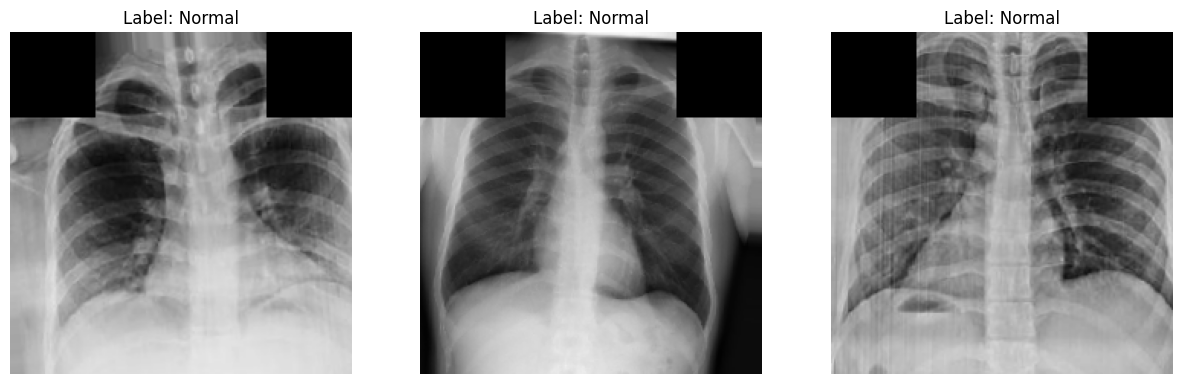


Sample Tuberculosis Images:


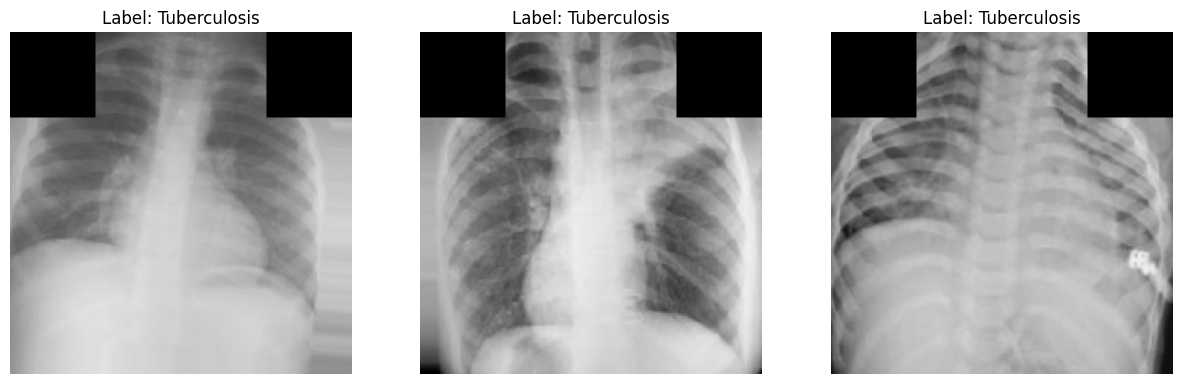

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get a batch of images
x_batch, y_batch = next(train_generator)

# 2. Get the label names (flip the dictionary)
# Result: {0: 'Normal', 1: 'Tuberculosis'}
label_map = {v: k for k, v in train_generator.class_indices.items()}

# 3. Separate images by class so we can show specific examples
normal_images = [x_batch[i] for i in range(len(y_batch)) if y_batch[i] == 0]
tb_images = [x_batch[i] for i in range(len(y_batch)) if y_batch[i] == 1]

# 4. Plotting Function
def show_samples(images, title, count=3):
    plt.figure(figsize=(15, 5))
    # Handle case if we have fewer images than requested
    limit = min(len(images), count)
    
    for i in range(limit):
        ax = plt.subplot(1, count, i + 1)
        img = images[i].astype('uint8') 
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

# 5. Show 3 Normal Images
if len(normal_images) > 0:
    print("\nSample Normal Images:")
    show_samples(normal_images, "Label: Normal")
else:
    print("No Normal images in this random batch. Run the cell again.")

# 6. Show 3 Tuberculosis Images
if len(tb_images) > 0:
    print("\nSample Tuberculosis Images:")
    show_samples(tb_images, "Label: Tuberculosis")
else:
    print("No TB images in this random batch. Run the cell again.")

In [6]:
def build_model():
    # 1. Define Input Shape
    input_shape = (224, 224, 3) 

    # 2. Load the Pre-trained Base Model
    # include_top=False: Removes the final 1000-class layer (ImageNet head)
    # weights='imagenet': Loads the pre-trained knowledge
    model = EfficientNetB0(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )

    # 3. Freeze the Base Model
    # We set trainable=False so we don't destroy the pre-trained patterns 
    # while our new "head" layers are initialized with random weights.
    model.trainable = False

    # 4. Build the Classification Head
    x = model.output
    
    # Global Average Pooling: Converts the 3D feature map into a 1D vector
    x = GlobalAveragePooling2D()(x)
    
    # Output Layer: 1 neuron with sigmoid activation for Binary Classification
    # (0 = Normal, 1 = Tuberculosis)
    output = Dense(1, activation='sigmoid')(x)

    # 5. Assemble the final model
    model = Model(inputs=model.input, outputs=output)
    
    return model

# Instantiate the model
model = build_model()

# Verify the structure
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
# Use label smoothing to prevent overconfidence
# If 0.05  not 0 and if 0.95 not 1
model.compile(
    optimizer=Adam(learning_rate=0.0001), # Make the learning rate 0.0001
    loss=loss_fn,  
    metrics=["accuracy", "AUC"]
)

In [8]:
# 1. Define Callbacks
checkpoint = ModelCheckpoint(
    'v7_efficientnetb0_tb_best.keras', 
    monitor='val_loss',      
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',         
    patience=5,                 
    verbose=1,
    restore_best_weights=True,  
    mode='min'                  
)

# 2. Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=100,  
    callbacks=[checkpoint, reduce_lr, early_stop]
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.7039 - accuracy: 0.6080 - loss: 0.6537
Epoch 1: val_loss improved from None to 0.51093, saving model to v7_efficientnetb0_tb_best.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - AUC: 0.8043 - accuracy: 0.7049 - loss: 0.6079 - val_AUC: 0.9299 - val_accuracy: 0.8573 - val_loss: 0.5109 - learning_rate: 1.0000e-04
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9323 - accuracy: 0.8505 - loss: 0.5029
Epoch 2: val_loss improved from 0.51093 to 0.42627, saving model to v7_efficientnetb0_tb_best.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - AUC: 0.9387 - accuracy: 0.8583 - loss: 0.4871 - val_AUC: 0.9664 - val_accuracy: 0.8880 - val_loss: 0.4263 - learning_rate: 1.0000e-04
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9568 - accuracy: 0.8787 - loss: 0.4392
Epoch 3: val_loss improved from 0.42627 to 0.37990, saving model to v7_efficientnetb0_tb_best.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - AUC

In [9]:
# 1. Unfreeze Base Model secara parsial
model.trainable = True

# 2. Freeze BatchNormalization Layers
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# 3. Freeze early layers, train only the last 60 layers
fine_tune_at = len(model.layers) - 60
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

# 4. Compile with very low Learning Rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=["accuracy", "AUC"]
)

# 5. Callbacks For Fine Tuning
ft_callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1),
    
    ModelCheckpoint(
        'v7_finetuned_best.keras', 
        monitor='val_loss', 
        save_best_only=True, 
        mode='min', 
        verbose=1
    )    
]

# 6. Fine Tune
history_fine = model.fit(
    train_generator,
    epochs=20, 
    validation_data=val_generator,
    callbacks=ft_callbacks
)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - AUC: 0.9985 - accuracy: 0.9848 - loss: 0.2527
Epoch 1: val_loss improved from None to 0.26443, saving model to v7_finetuned_best.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 66s 549ms/step - AUC: 0.9989 - accuracy: 0.9860 - loss: 0.2526 - val_AUC: 0.9995 - val_accuracy: 0.9760 - val_loss: 0.2644
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - AUC: 0.9989 - accuracy: 0.9856 - loss: 0.2534
Epoch 2: val_loss did not improve from 0.26443
110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 532ms/step - AUC: 0.9991 - accuracy: 0.9857 - loss: 0.2516 - val_AUC: 0.9995 - val_accuracy: 0.9760 - val_loss: 0.2645
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - AUC: 0.9993 - accuracy: 0.9890 - loss: 0.2482
Epoch 3: val_loss did not improve from 0.26443
110/110 ━━━━━━━━━━━━━━━━━━━━ 58s 524ms/step - AUC: 0.9993 - accuracy: 0.9869 - loss: 0.2494 - val_AUC: 0.9995 - val_accuracy: 0.9760 - val_loss: 0.2646
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step -

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step
--- Results with Threshold 0.5 ---
Accuracy: 0.9827 (98.27%)
------------------------------
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98       375
Tuberculosis       1.00      0.97      0.98       375

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



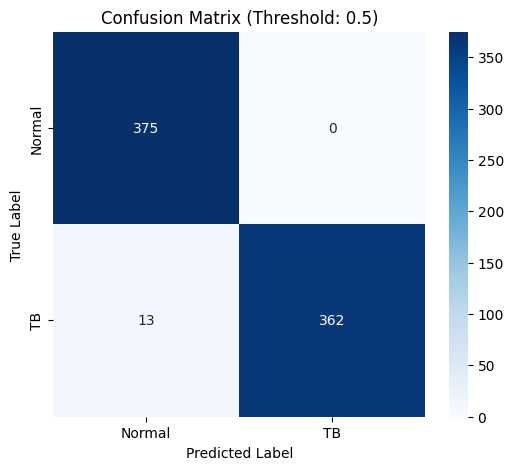

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Get the raw probabilities
y_pred_probs = model.predict(test_generator)

# 2. Input Threshold
new_threshold = 0.5
y_pred_new = (y_pred_probs > new_threshold).astype(int)

# 3. Calculate Accuracy
accuracy = accuracy_score(test_generator.classes, y_pred_new)

print(f"--- Results with Threshold {new_threshold} ---")
print(f"Accuracy: {accuracy:.4f} ({accuracy:.2%})") # Menampilkan akurasi (contoh: 0.9500 (95.00%))
print("-" * 30)
print(classification_report(test_generator.classes, y_pred_new, target_names=['Normal', 'Tuberculosis']))

# 4. Make Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(test_generator.classes, y_pred_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'TB'], yticklabels=['Normal', 'TB'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Threshold: {new_threshold})')
plt.show()

In [ ]:
# Helper function to scan directories and retrieve file paths
def get_file_list(directory):
    filepaths = []
    labels = []
    # Assumes directory structure: dataset/class_name/image_file
    classes = sorted(os.listdir(directory)) # e.g., ['Normal', 'Tuberculosis']
    
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                # Filter for valid image extensions
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    filepaths.append(os.path.join(class_path, file))
                    labels.append(class_name)
    return filepaths, labels

# 1. Retrieve data from the Training Directory
train_paths, train_labels = get_file_list(train_dir)

# 2. Retrieve data from the Validation Directory
val_paths, val_labels = get_file_list(val_dir)

# 3. CONCATENATE: Merge lists to create one large pool of data
full_filepaths = train_paths + val_paths
full_labels = train_labels + val_labels

# 4. Create the Combined DataFrame (The "Full Dataset")
full_df = pd.DataFrame({
    'filepath': full_filepaths,
    'label': full_labels
})

print(f"Train Samples: {len(train_paths)}")
print(f"Val Samples  : {len(val_paths)}")
print(f"Total Merged Dataset: {len(full_df)}")

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
import numpy as np
import tensorflow as tf

# --- CONFIGURATION ---
K_FOLDS = 5
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5  

# --- MODEL FACTORY FUNCTION ---
# We wrap the model creation in a function to ensure 
# we get a fresh, untrained model for every fold.
def get_model():
    # Load EfficientNetB0 (Pre-trained on ImageNet)
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False # Freeze base layers initially
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid') # Sigmoid for Binary Classification
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- DATA AUGMENTATION ---
# Augmentation applied only to the Training subset during K-Fold
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,,
    rotation_range=5,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for Validation subset (Rescale only)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)

# --- START K-FOLD CROSS VALIDATION ---
# StratifiedKFold ensures the ratio of TB/Normal is preserved in every fold
kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

cv_accuracies = []

print("\n==============================")
print("  CROSS VALIDATION EVALUATION ")
print("==============================")

# Loop through the K-Fold splits based on the DataFrame index
fold_num = 1
for train_index, val_index in kf.split(full_df['filepath'], full_df['label']):
    
    print(f"\n--- Fold {fold_num}/{K_FOLDS} ---")
    
    # 1. Split DataFrame into Train and Validation for this specific fold
    train_fold_df = full_df.iloc[train_index]
    val_fold_df   = full_df.iloc[val_index]
    
    # 2. Create Data Generators (reading from the split DataFrames)
    train_gen = train_datagen.flow_from_dataframe(
        train_fold_df,
        x_col='filepath', y_col='label',
        target_size=IMG_SIZE,
        class_mode='binary',
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    val_gen = val_datagen.flow_from_dataframe(
        val_fold_df,
        x_col='filepath', y_col='label',
        target_size=IMG_SIZE,
        class_mode='binary',
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    # 3. Initialize a Fresh Model
    model = get_model()
    
    # 4. Train the Model on the current fold
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        verbose=1
    )
    
    # 5. Evaluate Performance on the Validation subset
    score = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold_num} Accuracy: {score[1]*100:.2f}%")
    
    cv_accuracies.append(score[1])
    
    # 6. Clear Memory (Critical to prevent OOM errors in loop)
    tf.keras.backend.clear_session()
    fold_num += 1

# Final Results
print("\n===== CROSS VALIDATION SUMMARY =====")
print(f"Mean Accuracy : {np.mean(cv_accuracies)*100:.2f}%")
print(f"Std Deviation : {np.std(cv_accuracies)*100:.2f}%")

Checking image path: Image For Testing/Tuberculosis - Mixed/TB.3.jpg
Result: TUBERCULOSIS (96.95%)


d:\AI\AI Tuberculosis\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


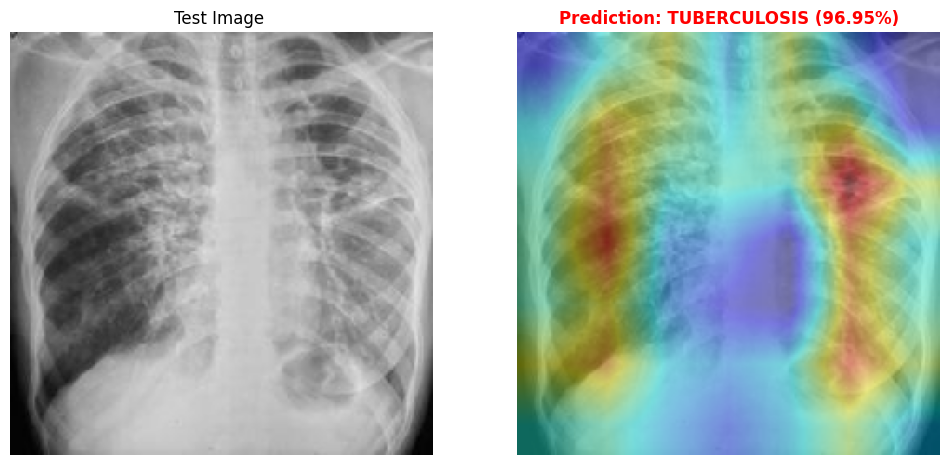

In [12]:
# --- 1. CONFIGURATION ---
MODEL_PATH = 'v7_efficientnetb0_tb_best.keras' 
IMG_SIZE = (224, 224) 
LAST_CONV_LAYER = 'top_activation' # Change to 'block6a_expand_activation' for smoother heatmap
THRESHOLD = 0.5

# --- 2. GRAD-CAM FUNCTION ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- 3. MAIN EXECUTION ---

# A. Load Image
target_img_path = 'Image For Testing/Tuberculosis - Mixed/TB.3.jpg' 
print(f"Checking image path: {target_img_path}")

# B. Load Model
model = load_model(MODEL_PATH, compile=False)
model.layers[-1].activation = None 

# C. Process Image (SPLIT LOGIC: AI vs HUMAN)
img = load_img(target_img_path, target_size=IMG_SIZE)
original_array = img_to_array(img) # This is the clean/pure array

# --- 1. Prepare Masked Version ---
masked_array = original_array.copy() # Copy it so we don't mess up the original
h, w, _ = masked_array.shape
mask_h, mask_w = int(h * 0.30), int(w * 0.30) # 30% Masking

# Black out corners ONLY on the masked_array
masked_array[0:mask_h, 0:mask_w, :] = 0.0 
masked_array[0:mask_h, w-mask_w:w, :] = 0.0 

# --- 2. Prepare Input Tensor (AI consumes the Masked version) ---
img_tensor = np.expand_dims(masked_array, axis=0)
img_tensor = preprocess_input(img_tensor)

# --- 3. Prepare Display Image (Human sees the Clean version) ---
img_display = original_array.astype('uint8') 

# --- PREDICTION (AI predicts based on the masked image) ---
preds = model.predict(img_tensor, verbose=0)
raw_score = tf.nn.sigmoid(preds[0][0]).numpy()

if raw_score > THRESHOLD:
    label = "TUBERCULOSIS"
    confidence = raw_score * 100
    text_color = 'red'
else:
    label = "NORMAL"
    confidence = (1 - raw_score) * 100
    text_color = 'green'

print(f"Result: {label} ({confidence:.2f}%)")

# D. Generate Heatmap (Based on the masked tensor)
heatmap = make_gradcam_heatmap(img_tensor, model, LAST_CONV_LAYER)

# E. Overlay (Paste the Heatmap onto the CLEAN Image)
heatmap_resized = cv2.resize(heatmap, IMG_SIZE)
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

# Key Step: Heatmap is added to 'img_display' (the clean one)
superimposed_img = cv2.addWeighted(img_display, 0.6, heatmap_color, 0.4, 0)

# F. Plot/Display
plt.figure(figsize=(12, 6))

# Left Image: Show the original image
plt.subplot(1, 2, 1)
plt.imshow(img_display)
plt.title("Test Image ")
plt.axis('off')

# Right Image: Overlay Heatmap on top of clean image
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title(f"Prediction: {label} ({confidence:.2f}%)", 
          color=text_color, fontsize=12, fontweight='bold')
plt.axis('off')

plt.show()